In [214]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__, hub.__version__)

2.6.0 0.12.0


## data preprocessing

* unzipping zip files 
* turning csv file into pandas dataframe





In [215]:
# from zipfile import ZipFile

# with ZipFile('../data/dog_vision_data/train/train.zip', 'r') as zipObj:
   
#    zipObj.extractall('../data/dog_vision_data/train/') 


# with ZipFile('../data/dog_vision_data/test/test.zip', 'r') as zipObj:
   
#    zipObj.extractall('../data/dog_vision_data/test/') 


# with ZipFile('../data/dog_vision_data/sample_submission/sample_submission.csv.zip', 'r') as zipObj:
   
#    zipObj.extractall('../data/dog_vision_data/sample_submission/') 

In [216]:
labels_csv = pd.read_csv("../data/dog_vision_data/labels.csv")

* identifying amount of pictures we have for each breed and visualising it

<AxesSubplot:>

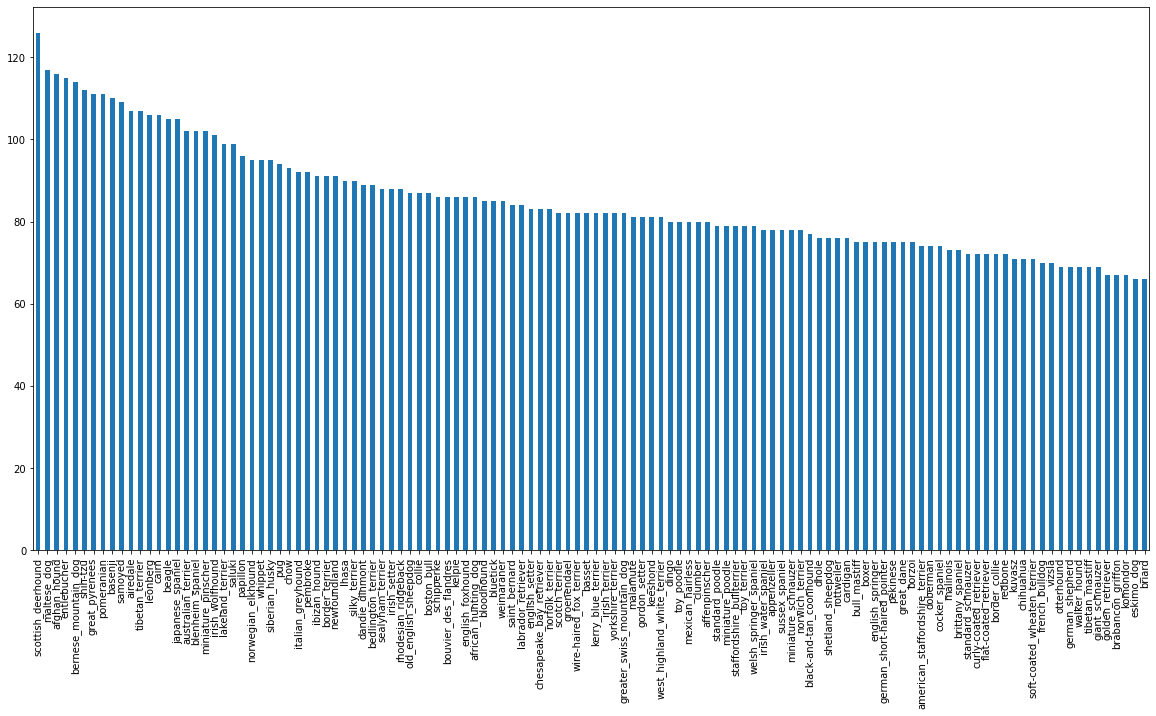

In [217]:
%matplotlib inline
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

* create file paths for each image
* check whether the amounts match

In [218]:
from IPython.display import Image

filenames = ['../data/dog_vision_data/train/' + fname + '.jpg' for fname in labels_csv['id']]

In [219]:
import os

if len(os.listdir("../data/dog_vision_data/train/"))-1 == len(filenames):
  #-1 because extracted zip file remains in the same folder
  print('Filenames amounts match')
else:
  print('Filenames amounts do not match')

Filenames amounts match


## cute dog


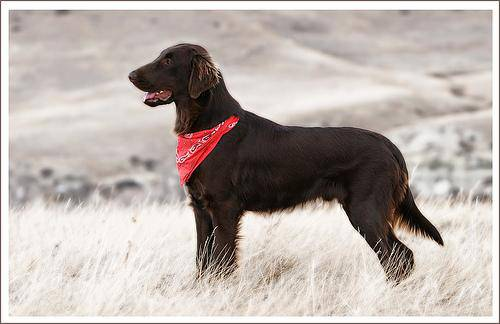

In [220]:
Image(filenames[1011])

In [221]:
    # convert labels column to NumPy array
import numpy as np
labels = labels_csv["breed"].to_numpy()
    # find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [222]:
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [223]:
    # turing labels into boolean arrays
bool_labels = [i == unique_breeds for i in labels]
bool_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [224]:
len(bool_labels) == len(labels)

True

## creating validation set

starting off with 2000 images for experimentation and validation before moving on to large scale model


In [225]:
X = filenames
y = bool_labels
IM_NUM = 2000

In [226]:
from sklearn.model_selection import train_test_split
    #splitting data into training and validation sets and setting up a random state within
X_train, X_val, y_train, y_val = train_test_split(X[:IM_NUM],
                                                  y[:IM_NUM],
                                                  test_size = 0.2,
                                                  random_state = 42)
len(X_train), len(X_val)

(1600, 400)

## image preprocessing

In [227]:
IMG_SIZE = 224
def process_image(image_path, img_size = 224):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (RBG)
  image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
    
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Turning data into batches

Friends dont let friends use minibatches larger than 32.



In [228]:
    # creating tuples with images and associated labels
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label
  """
  image = process_image(image_path)
  return image, label

In [229]:
BATCH_SIZE = 32


def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    '''
    creates data batches fom X images and y label pairs.
    shuffles data when it's training data and doesn't when it's validation data.
    accepts test data as input even without labels.
    '''
    
    if test_data:
        print('creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
  
    elif valid_data:
        print('creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                   tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print('creating training data batches...')
        
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels        
        data = data.shuffle(buffer_size=len(x))
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [230]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

creating training data batches...
creating validation data batches...


In [231]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## visualising batches

In [232]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_img):

    plt.figure(figsize=(15,10))

    for i in range(num_img):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis('off')


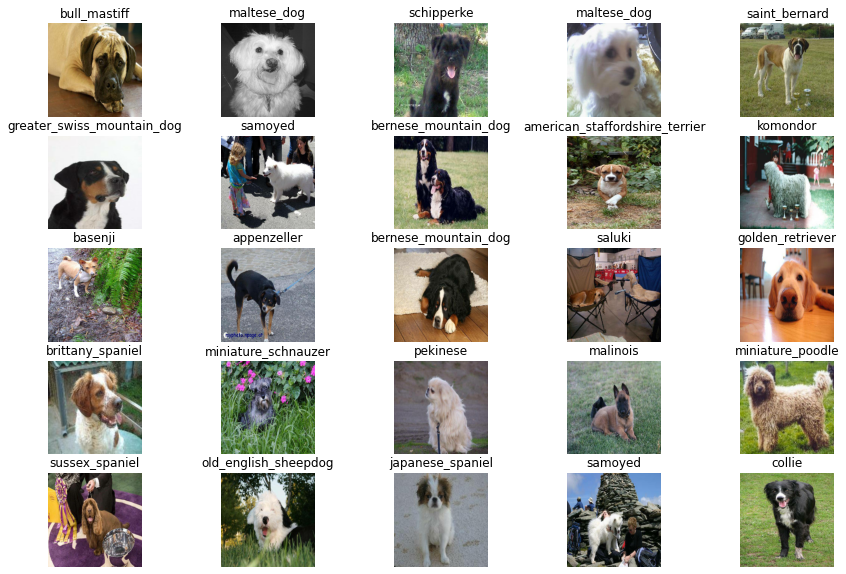

In [233]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images,train_labels, 25)

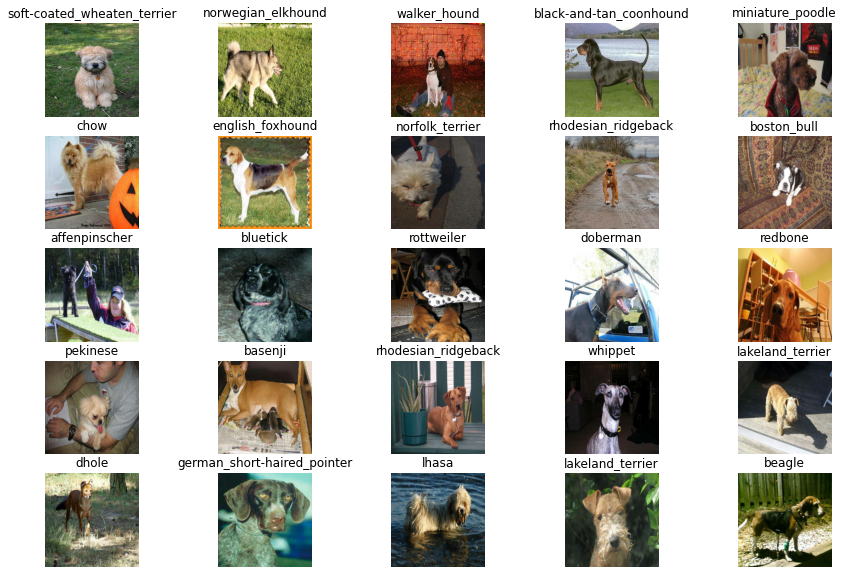

In [235]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_images(val_images, val_labels, 25)

## creating and training a model

In [236]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

In [240]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print('Building model with', MODEL_URL)

    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units = output_shape,
                              activation = 'softmax')
    ])

    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )

    model.build(INPUT_SHAPE)

    return model


In [242]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [243]:
%load_ext tensorboard

In [244]:
import datetime 

def create_tensorboard_callback():

    logdir = os.path.join('../dog_vision/logs',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))    
    return tf.keras.callbacks.TensorBoard(logdir)
     

In [245]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              patience = 3)